In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import string

from bs4 import BeautifulSoup
from shapely.geometry import Point, Polygon
from urllib.parse import urljoin

## Base Map: UK Counties

In [2]:
# Source: https://www.ukpostcode.net/shapefile-of-uk-administrative-counties-wiki-16.html
counties = gpd.read_file('datasets/UK/UK_counties/Map_UK.shp', crs='epsg:32630')

(-185523.71342924781, 871502.387163905, 5468290.709205763, 6808384.907171282)

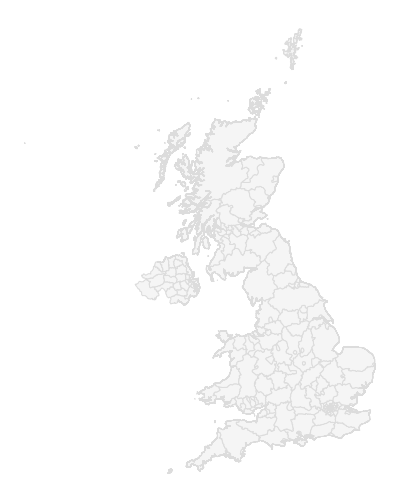

In [3]:
base = counties.plot(figsize=(9,9), color='whitesmoke', edgecolor='gainsboro')
base.axis('off')

In [4]:
counties.crs

<Derived Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
counties.loc[counties['NAME_1'] == 'England']

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,HASC_2,CC_2,TYPE_2,ENGTYPE_2,VALIDFR_2,VALIDTO_2,REMARKS_2,Shape_Leng,Shape_Area,geometry
0,80,GBR,United Kingdom,1030,England,13936,Barking and Dagenham,None,None,GB.BA,None,London Borough,London Borough,None,Present,None,0.368272,0.004932,"POLYGON ((719316.591 5716960.249, 719365.616 5..."
1,80,GBR,United Kingdom,1030,England,13937,Bath and North East Somerset,None,None,GB.BN,None,Unitary Authority,Unitary Authority,19960401,Present,None,1.146163,0.039882,"POLYGON ((550019.968 5696813.117, 550299.618 5..."
2,80,GBR,United Kingdom,1030,England,13938,Bedfordshire,None,None,GB.BD,None,Administrative County,Administrative County,~1989,Present,None,2.158565,0.147815,"POLYGON ((679380.073 5794077.687, 679674.028 5..."
3,80,GBR,United Kingdom,1030,England,13939,Berkshire,None,None,GB.BK,None,County,County,Between 1900 and 1974,Present,non-metropolitan county with no county council,2.825418,0.158283,"POLYGON ((658761.890 5714402.155, 659890.480 5..."
4,80,GBR,United Kingdom,1030,England,13940,Bexley,None,None,GB.XB,None,London Borough,London Borough,None,Present,None,0.452624,0.008851,"POLYGON ((721667.295 5708401.122, 721818.676 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,80,GBR,United Kingdom,1030,England,14043,West Yorkshire,None,None,GB.WY,None,Metropolitan County,Metropolitan County,19740401,Present,None,2.711164,0.276423,"POLYGON ((573672.433 5979954.150, 574059.478 5..."
108,80,GBR,United Kingdom,1030,England,14044,Westminster,None,None,GB.WE,None,London Borough (city),London Borough (city),None,Present,None,0.281644,0.002742,"POLYGON ((696535.612 5712807.900, 697032.209 5..."
109,80,GBR,United Kingdom,1030,England,14045,Wiltshire,None,None,GB.WL,None,Administrative County,Administrative County,Between 1900 and 1974,Present,None,3.652696,0.409599,"POLYGON ((584568.563 5723977.927, 585888.651 5..."
110,80,GBR,United Kingdom,1030,England,14046,Worcestershire,None,None,GB.WC,None,Administrative County,Administrative County,Between 1900 and 1974,Present,None,3.085356,0.234855,"POLYGON ((552987.902 5809768.935, 556366.848 5..."


Text(860000.0, 5720000.0, 'London')

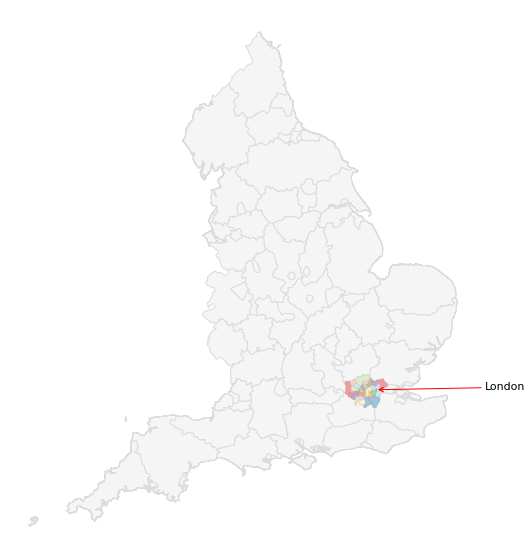

In [6]:
england = counties.loc[counties['NAME_1'] == 'England']
base = england.plot(figsize=(10,10), color='whitesmoke', edgecolor='gainsboro')
london = (england.loc[counties['TYPE_2']
                      .isin([
                             'London Borough',
                             'London Borough (city)',
                             'London Borough (royal)'])])
london.plot(ax=base, column='NAME_2', cmap='Paired', alpha=0.4, zorder=1)

base.axis('off')

plt.annotate(text='London',
             xy=(7.15e5, 5.71e6),
             xytext=(8.6e5, 5.72e6),
             horizontalalignment='left',
             verticalalignment='top',
             fontsize=11,
             arrowprops={'arrowstyle': '->', 'color': 'red'},
             color='black')

## UK Universities from UCAS

In [7]:
# Scrape from https://www.ucas.com/explore/unis?letter=<parameter>

# THE CODE IN THIS CELL WILL BE MOVED TO A SEPARATE HELPER SCRIPT

# start_url = 'https://www.ucas.com/explore/unis'
# params = {'letter': None}
# all_letters = string.ascii_lowercase
# universities = []

# for letter in all_letters:
#     params['letter'] = letter
#     print(f'Getting all universities from letter {letter}')
#     response = requests.get(start_url, params=params)
#     results_soup = BeautifulSoup(response.content)
    
#     # get each university name and location
#     unis = results_soup.select('.link-container__link')
#     print(f'  Got {len(unis)}')
#     for uni in unis:
#         uni_name = uni.get('title')
#         uni_url = urljoin(start_url, uni.get('href'))
#         response = requests.get(uni_url)
#         uni_content_soup = BeautifulSoup(response.content)
#         location = uni_content_soup.select_one('.content-block__section.content-block__section--grow p').text
#         address_components = location.split(',')
#         if len(address_components) > 2:
#             postcode = address_components[-1].strip()
#             county = address_components[-2].strip()
#         elif len(address_components) == 1:
#             postcode = None
#             county = address_components[0].strip()
#         else:
#             postcode = county = None
    
#         uni_data = {'name': uni_name, 'url': uni_url, 'address': location, 'postcode': postcode, 'county': county}
#         universities.append(uni_data)

In [8]:
# pd.DataFrame(universities).to_csv('datasets/UK/ucas_universities_2022.csv', index=False)

In [9]:
ucas_unis = pd.read_csv('datasets/UK/ucas_universities_2022.csv')
len(ucas_unis)

340

In [10]:
ucas_unis.head()

,name,url,address,postcode,county
0,University of Aberdeen,https://www.ucas.com/explore/unis/3a023828/uni...,"King's College, Aberdeen, AB24 3FX",AB24 3FX,Aberdeen
1,Abertay University,https://www.ucas.com/explore/unis/1558119a/abe...,"Kydd Building, Bell Street, Dundee, Tayside, D...",DD1 1HG,Tayside
2,Aberystwyth University,https://www.ucas.com/explore/unis/168d2cd8/abe...,"Penglais Campus, Penglais Campus, Aberystwyth,...",SY23 3FB,Ceredigion
3,ACM (The Academy of Contemporary Music),https://www.ucas.com/explore/unis/3d3a3bb5/acm...,"The Rodboro Building, Bridge Street,, Guildfor...",GU1 4SB,Surrey
4,Activate Learning,https://www.ucas.com/explore/unis/1630c359/act...,"Oxpens Road, Oxford, Oxfordshire, OX1 1SA",OX1 1SA,Oxfordshire


In [11]:
ucas_unis['county'].unique()

array(['Aberdeen', 'Tayside', 'Ceredigion', 'Surrey', 'Oxfordshire',
       'Angus', 'London', 'Cambridgeshire & Essex', 'Dorset', 'Devon',
       'North Yorkshire', 'West Midlands', 'West Yorkshire', 'Gwynedd',
       'Bedfordshire', 'South Yorkshire', 'Somerset', 'East Sussex',
       'Birmingham', 'County Durham', 'East Yorkshire', 'Lincolnshire',
       'Lancashire', 'Blackpool', 'Greater Manchester', 'Mid Glamorgan',
       'Gloucestershire', 'Holborn', 'Middlesex', 'Buckinghamshire',
       'Bury', 'Cambridgeshire', 'Cambridge', 'Kent', 'Cardiff',
       'Cheshire', 'Derbyshire', 'West Sussex', 'Norfolk', 'Essex',
       'Clwyd', 'Co Antrim', 'Cornwall', 'Bedford', 'Cumbria', 'Totnes',
       'Leicestershire', 'Edinburgh', 'Hampshire', 'Tyne and Wear',
       'Glasgow', 'Denbighshire', 'Carmarthenshire', 'Shropshire',
       'Worcestershire', 'Herefordshire', 'Hertfordshire', 'Highland',
       'Merseyside', 'Massachusetts', 'Staffordshire', 'Westminster',
       'Greater London'

In [12]:
# Correct some county names from univerities to be
# able to match exactly with the counties dataset
correction_map = {
    'Greater Manchester': 'Manchester',
    'Birmingham': 'Birmingham',
    'Cambridge': 'Cambridgeshire',
    'Lanarkshire': 'North Lanarkshire',
    'Stirlingshire': 'Stirling',
    'Tyne And Wear': 'Tyne and Wear',
    'County Durham': 'Durham',
    'Cambridgeshire & Essex': 'Cambridgeshire',
    'Co Antrim': 'Antrim'
}

for key,val in correction_map.items():
    ucas_unis.loc[ucas_unis['county'] == key, 'county'] = val

In [13]:
ucas_unis.loc[ucas_unis['county'].str.contains('Antrim')]

,name,url,address,postcode,county
72,"College of Agriculture, Food and Rural Enterprise",https://www.ucas.com/explore/unis/eaafa9fa/col...,"Greenmount Campus,, Muckamore, Antrim, Co Antr...",BT41 4PU,Antrim
233,Queen's University Belfast,https://www.ucas.com/explore/unis/3e45ece0/que...,"Inst of Lifelong Learning,, Belfast, Co Antrim...",BT7 1NN,Antrim


In [14]:
all_unis = ucas_unis.merge(counties, how='inner', left_on='county', right_on='NAME_2')

# We just want the unique university counties
all_unis = (all_unis
            .groupby('county')
            .agg({'geometry': lambda x: x,
                  'name': lambda x: list(x)})
            .reset_index())

# When aggregating by county, we'll need the county name, the list of universities 
# within that county, and the number of univerisities in that county.
# An aggrgated geopandas geometry column results into a GeometryArray object.
all_unis['count'] = (
    all_unis['geometry'].apply(
        lambda x: len(x) if isinstance(x, gpd.array.GeometryArray) else 1))
all_unis['geometry'] = (
    all_unis['geometry'].apply(
        lambda x: x[0] if isinstance(x, gpd.array.GeometryArray) else x))
all_unis['name'] = (
    all_unis['name'].apply(
        lambda x: ',\n'.join(y for y in x) if isinstance(x, list) else x.strip()))
all_unis_gdf = gpd.GeoDataFrame(all_unis,
                                geometry=all_unis['geometry'],
                                crs='epsg:32630')

all_unis_gdf.sort_values(by=['count'], ascending=False).head()

,county,geometry,name,count
35,London,"POLYGON ((703147.579 5711276.576, 703224.014 5...","Amity University [IN] London,\nARU London,\nBa...",60
36,Manchester,"POLYGON ((556637.719 5949836.409, 557350.857 5...","University of Bolton,\nFutureworks,\nHopwood H...",16
59,West Yorkshire,"POLYGON ((573672.433 5979954.150, 574059.478 5...","Backstage Academy,\nBradford College,\nUnivers...",12
57,West Midlands,"POLYGON ((574715.430 5830292.402, 575828.245 5...","Aston University, Birmingham,\nUniversity Coll...",11
41,North Yorkshire,"POLYGON ((643790.912 6047810.682, 643791.901 6...","University Centre Askham Bryan,\nCraven Colleg...",10


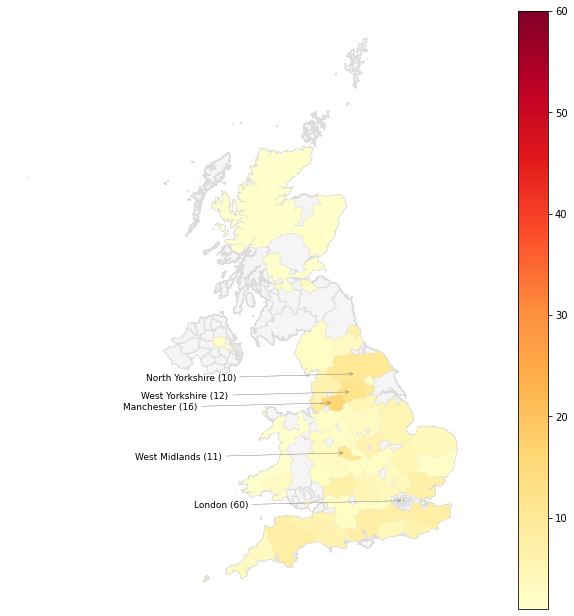

In [15]:
# Plot all universities in a map
base = counties.plot(figsize=(14,11), color='whitesmoke', edgecolor='gainsboro')
base.axis('off')

all_unis_gdf.plot(ax=base, column='count', cmap='YlOrRd', legend=True, zorder=1)

# Annotations
all_unis_gdf['coords'] = (
    all_unis_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
)
all_unis_gdf['coords'] = [coords[0] for coords in all_unis_gdf['coords']]

for idx, row in all_unis_gdf.loc[all_unis_gdf['count']>=10].iterrows():
    x = row['coords'][0]
    y = row['coords'][1]
    plt.annotate(text=f"{row['county']+' ('+str(row['count'])+')'}",
                 xy=(x,y-1e2),
                 xytext=(x-4.7e5, y),
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=9,
                 arrowprops={'arrowstyle': '->', 'color': 'dimgrey', 'linewidth': 0.4},
                 color='black')

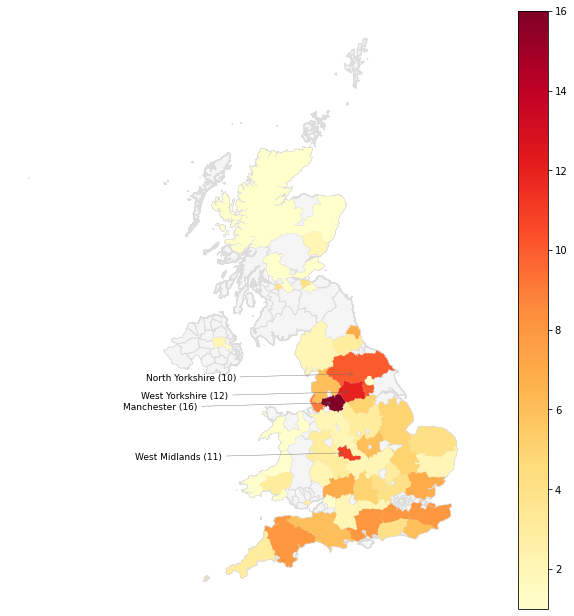

In [16]:
# Plot all universities EXCEPT LONDON
base = counties.plot(figsize=(14,11), color='whitesmoke', edgecolor='gainsboro')
base.axis('off')

all_unis_except_london = (
    all_unis_gdf.drop(all_unis_gdf.loc[all_unis_gdf['county'] == 'London'].index, axis=0)
)
all_unis_except_london.plot(ax=base, column='count', cmap='YlOrRd', legend=True, zorder=1)


all_unis_except_london['coords'] = (
    all_unis_except_london['geometry'].apply(lambda x: x.representative_point().coords[:])
)
all_unis_except_london['coords'] = [coords[0] for coords in all_unis_except_london['coords']]

for idx, row in all_unis_except_london.loc[all_unis_except_london['count']>=10].iterrows():
    x = row['coords'][0]
    y = row['coords'][1]
    plt.annotate(text=f"{row['county']+' ('+str(row['count'])+')'}",
                 xy=(x,y-1e2),
                 xytext=(x-4.7e5, y),
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=9,
                 arrowprops={'arrowstyle': '->', 'color': 'dimgrey', 'linewidth': 0.4},
                 color='black')

## Top UK universities

In [17]:
# Source: https://www.thecompleteuniversityguide.co.uk/league-tables/rankings
# Original download is .numbers, converted to .csv, with some manually deleted headers
rankings = pd.read_csv('datasets/UK/university_ranks.csv')
len(rankings)

130

In [18]:
rankings.head()

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score
0,1,University of Oxford,200,NaN,3.34,0.87,90.4,84.7,10.1,2842,599,99.1,1000
1,2,University of Cambridge,205,NaN,3.33,0.95,90.0,86.0,11.4,2718,1043,99.1,989
2,3,London School of Economics and Political Scien...,177,3.98,3.35,0.85,90.6,83.3,12.4,2051,853,96.5,963
3,4,University of St Andrews,208,4.30,3.13,0.82,79.9,79.6,11.1,2650,746,95.7,947
4,5,Imperial College London,194,3.99,3.36,0.92,95.1,86.7,11.1,2982,755,97.5,895


In [19]:
top_unis = rankings.merge(ucas_unis, how='inner', right_on='name', left_on='Institution')
len(top_unis)

129

One university was not mathed with the rankings data - find what that is and insert into the top_unis

In [20]:
mask = rankings['Institution'].isin(ucas_unis['name'])

In [21]:
rankings[~mask]

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score
11,12,University of Edinburgh,186,3.86,3.18,0.83,79.6,78.8,11.7,1407,808,93.3,801


In [22]:
ucas_unis.loc[ucas_unis['name'].str.contains('Edinburgh')]

,name,url,address,postcode,county
99,Edinburgh Napier University,https://www.ucas.com/explore/unis/dc3ccbfc/edi...,"Merchiston Campus\r\n10 Colinton Road, Edinbur...",EH10 5DT,Edinburgh
100,The University of Edinburgh,https://www.ucas.com/explore/unis/114bb2e7/the...,"Old College, South Bridge, Edinburgh, EH8 9YL",EH8 9YL,Edinburgh
231,"Queen Margaret University, Edinburgh",https://www.ucas.com/explore/unis/403c3afa/que...,"Queen Margaret Drive, Edinburgh, Musselburgh, ...",EH21 6UU,Edinburgh


In [23]:
# Correct University of Edinburgh
df1 = ucas_unis.loc[ucas_unis['name'] == 'The University of Edinburgh'].reset_index(drop=True)
df2 = rankings.loc[rankings['Institution'] == 'University of Edinburgh'].reset_index(drop=True)
edinburgh = pd.concat([df2, df1], axis=1)
top_unis = pd.concat([top_unis, edinburgh], axis=0).reset_index(drop=True).sort_values(by='Rank')

In [24]:
len(top_unis)

130

In [25]:
top_unis.head()

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score,name,url,address,postcode,county
0,1,University of Oxford,200,NaN,3.34,0.87,90.4,84.7,10.1,2842,599,99.1,1000,University of Oxford,https://www.ucas.com/explore/unis/351374e0/uni...,"Undergraduate Admissions Office, Wellington Sq...",OX1 2JD,Oxfordshire
1,2,University of Cambridge,205,NaN,3.33,0.95,90.0,86.0,11.4,2718,1043,99.1,989,University of Cambridge,https://www.ucas.com/explore/unis/badc3603/uni...,Cambridge Admissions Office\r\nStudent Service...,CB2 3PT,Cambridgeshire
2,3,London School of Economics and Political Scien...,177,3.98,3.35,0.85,90.6,83.3,12.4,2051,853,96.5,963,London School of Economics and Political Scien...,https://www.ucas.com/explore/unis/25fe3db7/lon...,"Houghton Street,, London, London, WC2A 2AE",WC2A 2AE,London
3,4,University of St Andrews,208,4.30,3.13,0.82,79.9,79.6,11.1,2650,746,95.7,947,University of St Andrews,https://www.ucas.com/explore/unis/81fe3292/uni...,"St Katharine's West, 16 The Scores, 16 The Sco...",KY16 9AX,Fife
4,5,Imperial College London,194,3.99,3.36,0.92,95.1,86.7,11.1,2982,755,97.5,895,Imperial College London,https://www.ucas.com/explore/unis/52087408/imp...,"Kensington, London, SW7 2AZ",SW7 2AZ,London


In [26]:
top_unis = top_unis.sort_values(by='Rank')
top_unis

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score,name,url,address,postcode,county
0,1,University of Oxford,200,NaN,3.34,0.87,90.4,84.7,10.1,2842,599,99.1,1000,University of Oxford,https://www.ucas.com/explore/unis/351374e0/uni...,"Undergraduate Admissions Office, Wellington Sq...",OX1 2JD,Oxfordshire
1,2,University of Cambridge,205,NaN,3.33,0.95,90.0,86.0,11.4,2718,1043,99.1,989,University of Cambridge,https://www.ucas.com/explore/unis/badc3603/uni...,Cambridge Admissions Office\r\nStudent Service...,CB2 3PT,Cambridgeshire
2,3,London School of Economics and Political Scien...,177,3.98,3.35,0.85,90.6,83.3,12.4,2051,853,96.5,963,London School of Economics and Political Scien...,https://www.ucas.com/explore/unis/25fe3db7/lon...,"Houghton Street,, London, London, WC2A 2AE",WC2A 2AE,London
3,4,University of St Andrews,208,4.30,3.13,0.82,79.9,79.6,11.1,2650,746,95.7,947,University of St Andrews,https://www.ucas.com/explore/unis/81fe3292/uni...,"St Katharine's West, 16 The Scores, 16 The Sco...",KY16 9AX,Fife
4,5,Imperial College London,194,3.99,3.36,0.92,95.1,86.7,11.1,2982,755,97.5,895,Imperial College London,https://www.ucas.com/explore/unis/52087408/imp...,"Kensington, London, SW7 2AZ",SW7 2AZ,London
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,126,University of Suffolk,110,3.96,NaN,NaN,74.4,80.9,16.5,1961,478,65.0,395,University of Suffolk,https://www.ucas.com/explore/unis/cf271b96/uni...,"Waterfront Building, Neptune Quay, Neptune Qua...",IP4 1QJ,Suffolk
125,127,University of East London,97,4.00,2.71,0.23,56.5,69.6,21.9,1105,756,76.5,374,University of East London,https://www.ucas.com/explore/unis/6d89f913/uni...,"University Way, London, London, E16 2RD",E16 2RD,London
126,128,"Glyndwr University, Wrexham",102,4.14,2.15,0.16,62.9,68.6,21.9,1334,559,73.3,364,"Glyndwr University, Wrexham",https://www.ucas.com/explore/unis/fdb6a3ab/gly...,"Mold Road, Mold Road, Wrexham, Denbighshire, L...",LL11 2AW,Denbighshire
127,129,Ravensbourne University London,113,3.80,NaN,NaN,70.0,77.5,22.6,1163,322,79.7,333,Ravensbourne University London,https://www.ucas.com/explore/unis/6f003a01/rav...,"6 Penrose Way,, London, London, SE10 0EW",SE10 0EW,London


In [27]:
top_X = top_unis[:50]
top_X

,Rank,Institution,Entry Standards,Student Satisfaction,Research Quality,Research Intensity,Graduate prospects outcomes,Graduate prospects on track,Student-Staff Ratio,Academic Services Spend,Facilities Spend,Degree Completion,Overall Score,name,url,address,postcode,county
0,1,University of Oxford,200,NaN,3.34,0.87,90.4,84.7,10.1,2842,599,99.1,1000,University of Oxford,https://www.ucas.com/explore/unis/351374e0/uni...,"Undergraduate Admissions Office, Wellington Sq...",OX1 2JD,Oxfordshire
1,2,University of Cambridge,205,NaN,3.33,0.95,90.0,86.0,11.4,2718,1043,99.1,989,University of Cambridge,https://www.ucas.com/explore/unis/badc3603/uni...,Cambridge Admissions Office\r\nStudent Service...,CB2 3PT,Cambridgeshire
2,3,London School of Economics and Political Scien...,177,3.98,3.35,0.85,90.6,83.3,12.4,2051,853,96.5,963,London School of Economics and Political Scien...,https://www.ucas.com/explore/unis/25fe3db7/lon...,"Houghton Street,, London, London, WC2A 2AE",WC2A 2AE,London
3,4,University of St Andrews,208,4.30,3.13,0.82,79.9,79.6,11.1,2650,746,95.7,947,University of St Andrews,https://www.ucas.com/explore/unis/81fe3292/uni...,"St Katharine's West, 16 The Scores, 16 The Sco...",KY16 9AX,Fife
4,5,Imperial College London,194,3.99,3.36,0.92,95.1,86.7,11.1,2982,755,97.5,895,Imperial College London,https://www.ucas.com/explore/unis/52087408/imp...,"Kensington, London, SW7 2AZ",SW7 2AZ,London
5,6,Durham University,184,4.02,3.14,0.79,85.3,82.3,13.5,2174,1085,96.8,889,Durham University,https://www.ucas.com/explore/unis/6e455568/dur...,"The Palatine Centre, Stockton Road, South Road...",DH1 3LE,Durham
6,7,Loughborough University,150,4.18,2.95,0.88,82.6,83.0,13.5,1853,1375,93.4,868,Loughborough University,https://www.ucas.com/explore/unis/b935bbb7/lou...,"Epinal Way, Loughborough, Leicestershire, LE11...",LE11 3TU,Leicestershire
7,8,UCL (University College London),185,3.95,3.22,0.91,85.3,83.4,10.1,2338,325,94.3,854,UCL (University College London),https://www.ucas.com/explore/unis/bd0c70d8/ucl...,"Gower Street, London, London, WC1E 6BT",WC1E 6BT,London
8,9,University of Warwick,162,4.05,3.22,0.83,83.7,81.5,12.8,1643,795,95.1,842,University of Warwick,https://www.ucas.com/explore/unis/e59d51a1/uni...,"University of Warwick, Coventry, West Midlands...",CV4 7AL,West Midlands
9,10,University of Bath,168,4.06,3.17,0.74,88.2,85.6,15.1,1913,703,96.0,840,University of Bath,https://www.ucas.com/explore/unis/295cc6a3/uni...,"University of BathClaverton Down, Claverton Do...",BA2 7AY,Somerset


In [28]:
# TRY: MERGE TOP UNIS WITH COUNTIES
all_top_unis = top_X.merge(counties, how='inner', left_on='county', right_on='NAME_2')
# all_top_unis[['county']]

# We just want the unique university counties
all_top_uni_counties = (all_top_unis
                        .groupby('county')
                        .agg({'geometry': lambda x: x,
                              'name': lambda x: list(x)})
                        .reset_index())

all_top_uni_counties['count'] = (
    all_top_uni_counties['geometry'].apply(
        lambda x: len(x) if isinstance(x, gpd.array.GeometryArray) else 1))
all_top_uni_counties['geometry'] = (
    all_top_uni_counties['geometry'].apply(
        lambda x: x[0] if isinstance(x, gpd.array.GeometryArray) else x))
all_top_uni_counties['name'] = (
    all_top_uni_counties['name'].apply(
        lambda x: ',\n'.join(y for y in x) if isinstance(x, list) else x.strip()))
all_top_counties_gdf = gpd.GeoDataFrame(all_top_uni_counties,
                                        geometry=all_top_uni_counties['geometry'],
                                        crs='epsg:32630')

all_top_counties_gdf.sort_values(by=['count'], ascending=False)

,county,geometry,name,count
19,London,"POLYGON ((703147.579 5711276.576, 703224.014 5...",London School of Economics and Political Scien...,7
9,Edinburgh,"MULTIPOLYGON (((482032.736 6205668.613, 482032...","The University of Edinburgh,\nHeriot-Watt Univ...",2
17,Leicestershire,"POLYGON ((656640.364 5853325.550, 657585.747 5...","Loughborough University,\nUniversity of Leicester",2
33,West Midlands,"POLYGON ((574715.430 5830292.402, 575828.245 5...","University of Warwick,\nAston University, Birm...",2
32,Tyne and Wear,"POLYGON ((591994.235 6101426.556, 594929.354 6...","Newcastle University,\nNorthumbria University,...",2
30,Surrey,"POLYGON ((677904.887 5701647.757, 678533.751 5...","Royal Holloway, University of London,\nUnivers...",2
24,Nottinghamshire,"POLYGON ((645469.869 5920822.964, 645868.152 5...","University of Nottingham,\nNottingham Trent Un...",2
25,Oxfordshire,"POLYGON ((620751.682 5773193.810, 620329.096 5...",University of Oxford,1
21,Merseyside,"POLYGON ((503513.885 5950709.067, 504442.141 5...",University of Liverpool,1
22,Norfolk,"POLYGON ((747639.007 5877328.112, 747640.599 5...",University of East Anglia UEA,1


## Map of top UK universities

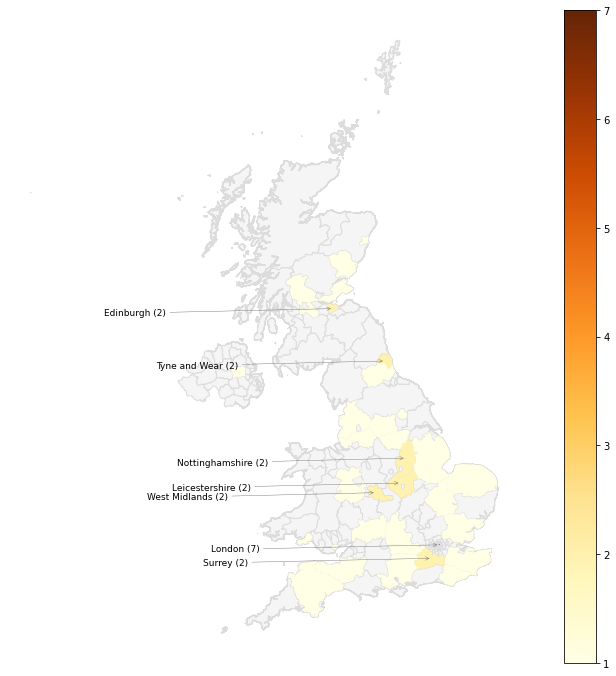

In [29]:
# Plot all top unis
base = counties.plot(figsize=(15,12), color='whitesmoke', edgecolor='gainsboro')
base.axis('off')

all_top_counties_gdf.plot(ax=base, column='count', cmap='YlOrBr', legend=True, zorder=1)

all_top_counties_gdf['coords'] = (
    all_top_counties_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
)
all_top_counties_gdf['coords'] = [coords[0] for coords in all_top_counties_gdf['coords']]

for idx, row in all_top_counties_gdf.loc[all_top_counties_gdf['count']>=2].iterrows():
    x = row['coords'][0]
    y = row['coords'][1]
    plt.annotate(text=f"{row['county']+' ('+str(row['count'])+')'}",
                 xy=(x,y-1e2),
                 xytext=(x-4.7e5, y),
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=9,
                 arrowprops={'arrowstyle': '->', 'color': 'dimgrey', 'linewidth': 0.4},
                 color='black')

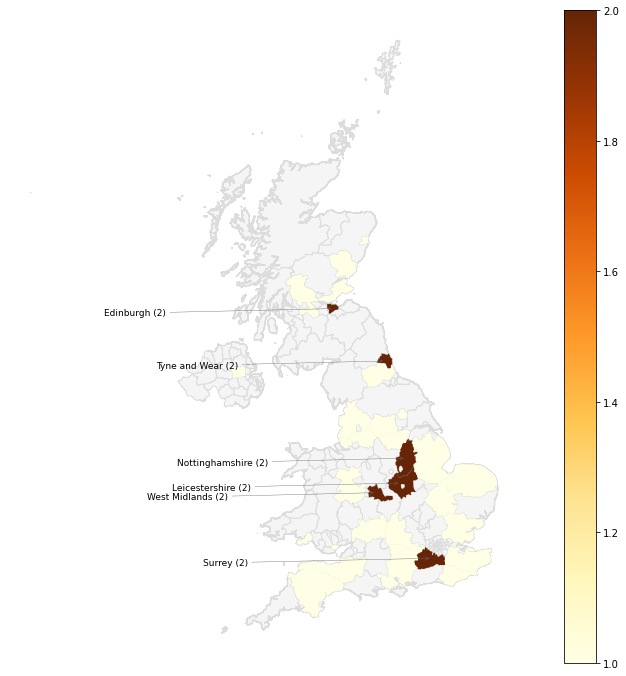

In [30]:
# Plot all top uni counties EXCEPT LONDON
base = counties.plot(figsize=(15,12), color='whitesmoke', edgecolor='gainsboro')
base.axis('off')

all_top_counties_gdf = (
    all_top_counties_gdf.drop(
        all_top_counties_gdf.loc[all_top_counties_gdf['county'] == 'London'].index,
        axis=0)
)

all_top_counties_gdf.plot(ax=base, column='count', cmap='YlOrBr', legend=True, zorder=1)

all_top_counties_gdf['coords'] = (
    all_top_counties_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
)
all_top_counties_gdf['coords'] = [coords[0] for coords in all_top_counties_gdf['coords']]

for idx, row in all_top_counties_gdf.loc[all_top_counties_gdf['count']>=2].iterrows():
    x = row['coords'][0]
    y = row['coords'][1]
    plt.annotate(text=f"{row['county']+' ('+str(row['count'])+')'}",
                 xy=(x,y-1e2),
                 xytext=(x-4.7e5, y),
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=9,
                 arrowprops={'arrowstyle': '->', 'color': 'dimgrey', 'linewidth': 0.4},
                 color='black')